## MCMC on UGC06787_rot dataset
We are going to be looking at data from the UGC06787_rot dataset. This contains rotational speed data on the galaxy UGC 6787. We are going to run some MCMC methods in order in order to find how sensitive our model is to the parameters of $r_0$(radius) and $p_0$(density) of dark matter. We are usign the same model as in the previous part of the project.

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import emcee

new_data=pd.read_csv('/Users/samholmes/Desktop/HW #5 data in the cosmos/UGC06787_rot.csv')
new_new_new_data=new_data[1:]
new_data['R_Dist(meters)']=new_data['R_dist(kpc)'].astype(float)*3.086e19
new_data['V_rot(m/s)']=new_data['Vobs(km/s)'].astype(float)*1e3
new_data['V_rot_err(m/s)']=new_data['errV(km/s)'].astype(float)*1e3
R_dist=new_data['R_Dist(meters)']
V_rot=new_data['V_rot(m/s)']
V_rot_err=new_data['V_rot_err(m/s)']

Next we create the functions that define our model and allow our MCMC to run. These are identical to the functions used in the previous notebook. If you would like a more detailed explanation of these functions please refer back to that section. To speed up our time of computation within the $M_{in}(r)$ we only integrate from $1\text{e}8$ to $r$ rather than from zero to $r$. This shouldn't affect our results very much as the density of dark matter is very low at these radii.

In [4]:
#Prior does not need to be tweaked
def p(r,r0,p0):
    if r<r0:
        return p0
    return 0


#This equation is designed to calculate the mass of the universe within a certain radius
#r_max represents the radius of the universe
#r_cur represents the radius you are evaluating the internal mass at 
def M_in(r,p0,r0):
    lst=[]
    for r1 in r:
        intergrand = lambda r_prime: 4*np.pi*p(r_prime,r0,p0)*(r_prime**2)
        result, _ = quad(intergrand,1e8,min(r1,r0))
        lst.append(result)
    return np.array(lst)



#This equation gives us the velocity at a certain radius of the universe
def velocity_profile(r,p0,r0):
    G = 6.6743e-11
    M = M_in(r,p0,r0)
    return np.sqrt(G*M/r)

#Does it make sense
def ln_prior(params):
    p0,r0 = params
    if p0>0 and r0>0:
        return 0
    return -np.inf

#Finds how well the model fits the data
def ln_likelihood(params,r,V_obs,V_err):
    p0,r0 = params
    v_model_pred = velocity_profile(r,p0,r0)
    return -0.5*np.sum((V_obs-v_model_pred)**2/V_err**2)

#Finds how likely the model is
def ln_pdf(params,r, V_obs, V_err):
    p=ln_prior(params)
    if p==-np.inf:
        return -np.inf
    return p + ln_likelihood(params,r,V_obs,V_err) 

Now we are ready to run our MCMC walkers. They are crawling two dimensions and comparing their values to the actual data from this galaxy in order to find the best fit. 

In [5]:
import numpy as np
n_walkers=16
ndim=2 
nsteps=2000
initial_postition = np.random.rand(n_walkers,ndim)
initial_postition[0]=initial_postition[0]*5e10
initial_postition[1]=initial_postition[1]*9e8
sampler = emcee.EnsembleSampler(n_walkers,ndim,ln_pdf,args=[new_data['R_Dist(meters)'],new_data['V_rot(m/s)'],new_data['V_rot_err(m/s)']])
sampler.run_mcmc(initial_postition,nsteps,progress=True)
samples = sampler.get_chain()

100%|██████████| 2000/2000 [00:31<00:00, 63.44it/s]


To be certain that our walkers converged to a specific range of values we will plot the walkers and their values. Conviently we can see that the walkers have converged. Additionally we remove the burn in period from the walker steps so in the future we can analyse them better. 

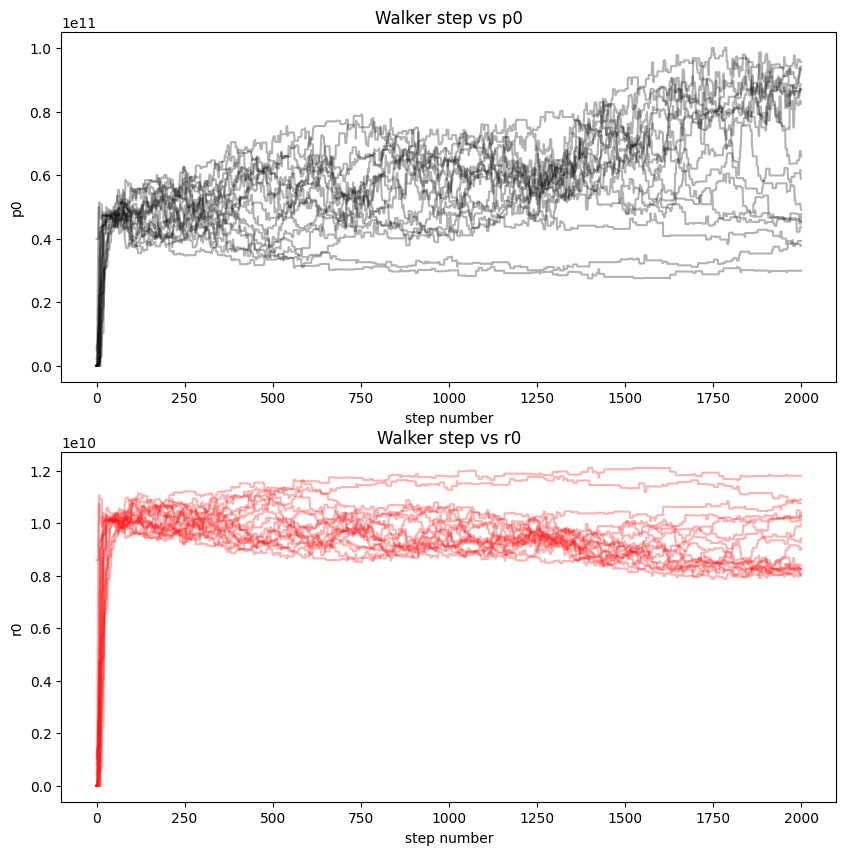

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(samples[:, :, 0], 'k', alpha=0.3)
axs[0].set_ylabel('p0')
axs[0].set_xlabel('step number')
axs[0].set_title('Walker step vs p0')

axs[1].plot(samples[:, :, 1], 'r', alpha=0.3)
axs[1].set_ylabel('r0')
axs[1].set_xlabel('step number')
axs[1].set_title('Walker step vs r0')

burn_in=100
samples2=samples[burn_in:,:,:]

Next we make a KDE plot showing us the distribution of the walkers step. This gives us a nice visualization of the "acceptable" values of our parameters $r_0$ and $p_0$. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


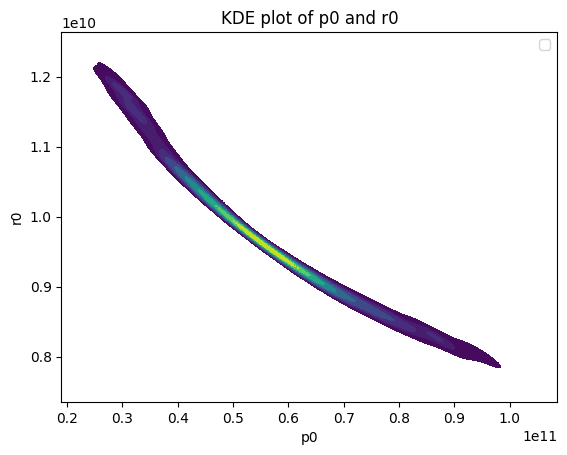

In [17]:
import seaborn as sns
sample_x=samples2[:,:,0].flatten()
sample_y=samples2[:,:,1].flatten()
sns.kdeplot(x=sample_x,y=sample_y,fill=True,cmap='viridis')
plt.xlabel('p0')
plt.ylabel('r0')
plt.title('KDE plot of p0 and r0')
plt.show()

Now we are going to compare our observed data to the model that we have created. First thing that we do is find the "best" values for $r_0$ and $p_0$ we then calculate out the expected rotation velocity with a  $1 \sigma$ range of the model. Notice how the $1 \sigma$ range of the model is incredibly tight. 
  
Next we plot the data itself with each point representing a data point. Notice how the model and the data do not really resemble each other. This shows you that MCMC can be used to optimize a model but does not efficently evaluate the accuracy of the model itself.

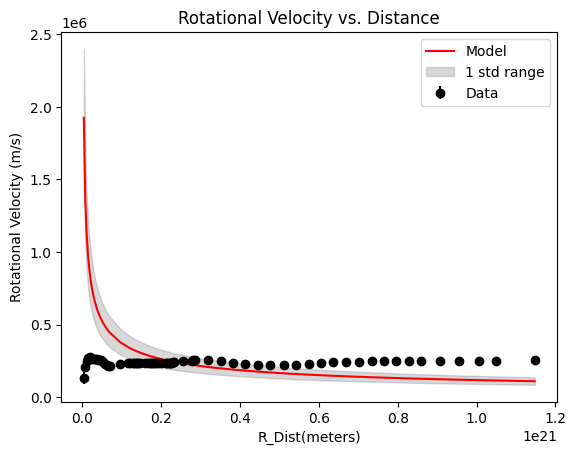

In [16]:
plt.errorbar(new_data['R_Dist(meters)'], new_data['V_rot(m/s)'], new_data['V_rot_err(m/s)'], fmt='o', color='black',label='Data')
medians = np.median(samples2, axis=0)
r0_medians = np.median(medians[:, 0])
p0_medians = np.median(medians[:, 1])

# calculate the standard deviation
r0_std = np.std(medians[:, 0])
p0_std = np.std(medians[:, 1])

# plot the velocity profile with shaded area for 1 standard deviation
plt.plot(new_data['R_Dist(meters)'], velocity_profile(new_data['R_Dist(meters)'], r0_medians, p0_medians), color='red', label='Model')
plt.xlabel('R_Dist(meters)')
plt.ylabel('Rotational Velocity (m/s)')
plt.fill_between(new_data['R_Dist(meters)'], velocity_profile(new_data['R_Dist(meters)'], r0_medians - r0_std, p0_medians - p0_std), 
                velocity_profile(new_data['R_Dist(meters)'], r0_medians + r0_std, p0_medians + p0_std), color='gray', alpha=0.3,label='1 std range')
plt.title('Rotational Velocity vs. Distance')
plt.legend()
plt.show()
